In [1]:
%matplotlib inline
from matplotlib import pyplot
import sys
sys.path.insert(0,'/home/ernie/caffe2/build')

from caffe2.python import core, model_helper, net_drawer, workspace, brew
from caffe2.proto import caffe2_pb2
import caffe2.python.models.SSDNet as SSDNet
import numpy as np

In [2]:
def AddInput(model, batch_size, db, db_type):
    data, gt_label = model.net.AnnotationInput(
        [],["Annodata","gt_label"],batch_size = 1,
        db=db, db_type = db_type,scale = 300, crop = 300,
        use_gpu_transform = 0, mirror = 1, warp = 1, color = 1,
        use_caffe_datum = 1,
        interp_mode = ["LINEAR","AREA","NEAREST","CUBIC","LANCZOS4"]
    )
    data = model.StopGradient(data, data)
    return data, gt_label

In [3]:
def AddSSDNetModel(model,data):
    mbox_layers = SSDNet.SSDNet(model,data)
    return mbox_layers

In [4]:
def AddConfReshape(model, conf, num_classes):
    model.net.Reshape([conf],["conf_reshape","shape_1"],shape=[-1,num_classes])
    model.net.Softmax("conf_reshape","conf_softmax")
    conf_softmax_flat=model.net.Reshape("conf_softmax",["conf_softmax_flat","shape_2"],shape=[1,-1])
    return conf_softmax_flat

In [5]:
def AddTrainingOperators(model, mbox_layers, gt_label):
    MultiboxInput = mbox_layers
    MultiboxInput.append(gt_label)
    loc_pred,loc_gt,conf_pred,conf_gt=model.net.MultiboxLoss(
    MultiboxInput,['loc_pred','loc_gt','conf_pred','conf_gt']
    )
    SmoothL1Loss = model.net.SmoothL1Loss([loc_pred,loc_gt],'SmoothL1Loss')
    P,SoftmaxWithLoss = model.net.SoftmaxWithLoss([conf_pred,conf_gt],["P","SoftmaxWithLoss"])
    model.AddGradientOperators([SmoothL1Loss,SoftmaxWithLoss])
    ITER = brew.iter(model,"iter")
    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.001,policy="step",stepsize=80000,gamma=0.1
        )
    ONE = model.param_init_net.ConstantFill([],"ONE",shape=[1],value=1.0)
    for param in model.params:
        param_grad = model.param_to_grad[param]
        model.WeightedSum([param, ONE, param_grad, LR],param)

In [6]:
train_model = model_helper.ModelHelper(name="ssd_train")
data, gt_label = AddInput(train_model, batch_size=1, 
                         db='/home/ernie/data/VOCdevkit/test/lmdb/test_trainval_lmdb',
                         db_type='lmdb')
mbox_layers = AddSSDNetModel(train_model, data)
AddTrainingOperators(train_model, mbox_layers, gt_label)

deploy_model = model_helper.ModelHelper(name="ssd_deploy", init_params=False)
mbox_layers = AddSSDNetModel(deploy_model, "data")
conf_softmax_flat = AddConfReshape(deploy_model, mbox_layers[1], 21)
mbox_layers[1] = 'conf_softmax_flat'
deploy_model.net.DetectionOutput(mbox_layers,["detection_out"]
                                ,num_classes=21,nms_threshold=0.45,keep_top_k=200,top_k_=400)
net_def = caffe2_pb2.NetDef()
with open('/home/ernie/caffemodel/VGG16_init_net.pb','r') as f:
    net_def.ParseFromString(f.read())
workspace.RunNetOnce(net_def)

True

In [7]:
losses_ = []
def UpdateSmoothedLoss(loss, iter_, average_loss, smoothed_loss):
    if len(losses_) < average_loss:
        losses_.append(loss)
        size = len(losses_)
        smoothed_loss = (smoothed_loss * (size - 1) + loss) / size
    else:
        idx = iter_ % average_loss
        smoothed_loss = smoothed_loss + (loss - losses_[idx]) / average_loss
        losses_[idx] = loss
    return smoothed_loss
workspace.RunNetOnce(train_model.param_init_net)
workspace.CreateNet(train_model.net, overwrite=True)
total_iters = 1000
loc_loss = np.zeros(total_iters)
conf_loss = np.zeros(total_iters)
smoothed_loss = 0
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    loc_loss[i] = workspace.FetchBlob('SmoothL1Loss')
    conf_loss[i] = workspace.FetchBlob('SoftmaxWithLoss')
    smoothed_loss = UpdateSmoothedLoss(loc_loss[i]+conf_loss[i], i ,10,smoothed_loss)
    print 'iters = ',i,'loss = ',smoothed_loss,'smooth = ',loc_loss[i],'softmax = ',conf_loss[i]

iters =  0 loss =  9.97600889206 smooth =  3.27326631546 softmax =  6.7027425766
iters =  1 loss =  8.27142906189 smooth =  2.52596473694 softmax =  4.04088449478
iters =  2 loss =  8.8838095665 smooth =  4.61106348038 softmax =  5.49750709534
iters =  3 loss =  9.68816554546 smooth =  6.70355987549 softmax =  5.39767360687
iters =  4 loss =  8.84761528969 smooth =  2.31239151955 softmax =  3.17302274704
iters =  5 loss =  8.38580989838 smooth =  2.88297200203 softmax =  3.19381093979
iters =  6 loss =  8.05012287412 smooth =  2.88042187691 softmax =  3.1555788517
iters =  7 loss =  7.69357922673 smooth =  2.17408800125 softmax =  3.02368569374
iters =  8 loss =  7.48450528251 smooth =  2.73314118385 softmax =  3.07877254486
iters =  9 loss =  7.31328725815 smooth =  2.75340771675 softmax =  3.01891732216
iters =  10 loss =  6.80087176561 smooth =  1.93850576878 softmax =  2.91334819794
iters =  11 loss =  6.62782734632 smooth =  1.97471523285 softmax =  2.86168980598
iters =  12 loss 

In [8]:
#test_net = core.Net("ssd_test")
#deploy_model = model_helper.ModelHelper(name="ssd_deploy", init_params=False)
#mbox_layers = AddSSDNetModel(deploy_model, 'data')
#conf_softmax_flat = AddConfReshape(deploy_model, mbox_layers[1], 21)
#mbox_layers[1] = "conf_softmax_flat"
#deploy_model.net.DetectionOutput(mbox_layers,["detection_out"]
#                                ,num_classes=21,nms_threshold=0.45,keep_top_k=200,top_k_=400)
data=np.load("transformed_image.npy")
data = data[np.newaxis, :, :, :]
workspace.FeedBlob('data',data)
workspace.RunNetOnce(deploy_model.param_init_net)
workspace.CreateNet(deploy_model.net, overwrite=True)
workspace.RunNet(deploy_model.net,1)
detections = workspace.FetchBlob('detection_out')
print detections.shape

(1, 1, 14, 7)


500 333
0.472975 0.509055 0.811928 1.01764
158 255 270 509


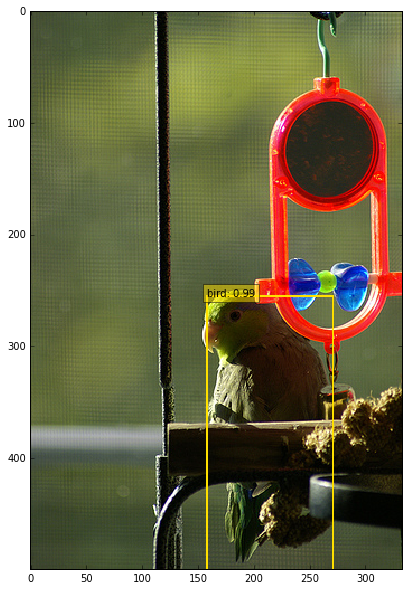

In [9]:
det_label = detections[0,0,:,1]
det_conf = detections[0,0,:,2]
det_xmin = detections[0,0,:,3]
det_ymin = detections[0,0,:,4]
det_xmax = detections[0,0,:,5]
det_ymax = detections[0,0,:,6]
#import numpy as np
import skimage.io
from scipy.ndimage import zoom
from skimage.transform import resize
#import matplotlib.pyplot as plt

pyplot.rcParams['figure.figsize'] = (10, 10)
pyplot.rcParams['image.interpolation'] = 'nearest'
pyplot.rcParams['image.cmap'] = 'gray'
def load_image(filename, color=True):
    img = skimage.img_as_float(skimage.io.imread(filename, as_grey=not color)).astype(np.float32)
    if img.ndim == 2:
        img = img[:, :, np.newaxis]
        if color:
            img = np.tile(img, (1, 1, 3))
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    return img
image = load_image('./2009_000898.jpg')
# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.1]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]
CLASSES = ('__background__', 
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')

pyplot.imshow(image)
currentAxis = pyplot.gca()
colors = pyplot.cm.hsv(np.linspace(0, 1, len(CLASSES))).tolist()
print image.shape[0],image.shape[1]
for i in xrange(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * image.shape[1]))
    ymin = int(round(top_ymin[i] * image.shape[0]))
    xmax = int(round(top_xmax[i] * image.shape[1]))
    ymax = int(round(top_ymax[i] * image.shape[0]))
    print top_xmin[i],top_ymin[i],top_xmax[i],top_ymax[i]
    print xmin,ymin,xmax,ymax
    score = top_conf[i]
    label = int(top_label_indices[i])
    display_txt = '%s: %.2f'%(CLASSES[label], score)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(pyplot.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})